<a href="https://colab.research.google.com/github/Chuck2Win/resnet_scratch/blob/master/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torchvision

In [127]:
train=torchvision.datasets.CIFAR10('./',True,transform=torchvision.transforms.ToTensor(),download=True)
test=torchvision.datasets.CIFAR10('./',False,transform=torchvision.transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
from sklearn.model_selection import train_test_split
train_data,val_data=train_test_split(train,test_size=0.2)

In [0]:
# class 내에서 함수 선언..

class resnet(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.first_conv=nn.Conv2d(3,16,3,1,1)
        self.conv1=nn.Sequential(nn.Conv2d(16,16,3,1,1),nn.BatchNorm1d(32),nn.ReLU(),nn.Conv2d(16,16,3,1,1),nn.BatchNorm1d(32))
        self.conv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),nn.BatchNorm1d(16),nn.ReLU(),nn.Conv2d(32,32,3,1,1),nn.BatchNorm1d(16))
        self.conv3=nn.Sequential(nn.Conv2d(64,64,3,1,1),nn.BatchNorm1d(8),nn.ReLU(),nn.Conv2d(64,64,3,1,1),nn.BatchNorm1d(8))
    
        
    
    def forward(self,input,n):
        '''
        input : [N,C,H,W] - [128,3,32,32]
        result1 : [128,16,32,32]
        result2 : [128,16,32,32]
        result2_ : [128,16,16,16]
        '''
        x=first_conv(input)
        ind=0
        while True:
            x=self.conv1(x)+x
            x=nn.ReLU(x)
            ind+=1
            if ind==n:
                break
        

        


In [0]:



class simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(self.model1,self.model2)
    def model1(self):
        nn.Linear(16,32)
    def model2(self):
        return nn.Linear(32,64)
    def forward(input):
        return self.model(input)

In [0]:
# nn.Sequential(*layers) 
# asterisk(*) : 컨테이너 타입의 데이터를 unpacking 할 때

layers=[]
layers.append(nn.Linear(10,10))
layers.append(nn.ReLU())
m=nn.Sequential(*layers)

In [132]:
l=[*m]*3
print(l)

[Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


In [0]:
class build_block1(nn.Module):
    def __init__(self,channel1,channel2):
        super().__init__()
        self.residual_1=nn.Sequential(nn.Conv2d(channel1,channel2,3,1,1),nn.BatchNorm2d(channel2),nn.ReLU(),nn.Conv2d(channel2,channel2,3,1,1),nn.BatchNorm2d(channel2))
        self.relu=nn.ReLU()
        
    def forward(self,input):
        return self.relu(self.residual_1(input)+input)
class build_block2(nn.Module):
    def __init__(self,channel1,channel2):
        super().__init__()
        self.residual_d=nn.Sequential(nn.Conv2d(channel1,channel2,3,2,1),nn.BatchNorm2d(channel2),nn.ReLU(),nn.Conv2d(channel2,channel2,3,1,1),nn.BatchNorm2d(channel2))
        self.conv_d=nn.Sequential(nn.Conv2d(channel1,channel2,1,2,0),nn.BatchNorm2d(channel2))        
        self.relu=nn.ReLU()
        
    def forward(self,input):
        return self.relu(self.residual_d(input)+self.conv_d(input))
        

In [0]:
class residual(nn.Module):
    def __init__(self,channels,n):
        super().__init__()
        layer_1_features=[]
        for _ in range(n):
            layer_1_features.append(build_block1(channels[0],channels[0]))
        self.layer_1=nn.Sequential(*layer_1_features)
        
        layer_2_features=[]
        layer_2_features.append(build_block2(channels[0],channels[1]))
        for i in range(1,n):
            layer_2_features.append(build_block1(channels[1],channels[1]))
        self.layer_2=nn.Sequential(*layer_2_features)

        layer_3_features=[build_block2(channels[1],channels[2])]
        for j in range(n-1):
            layer_3_features.append(build_block1(channels[2],channels[2]))
        self.layer_3=nn.Sequential(*layer_3_features)
        self.conv1=nn.Conv2d(3,channels[0],3,1,1)
        self.fc=nn.Sequential(nn.Linear(64*8*8,10),nn.BatchNorm1d(10),nn.ReLU())
    def forward(self,input):
        x=self.conv1(input)
        x=self.layer_1(x)
        x=self.layer_2(x)
        x=self.layer_3(x)
        x=x.reshape(-1,64*8*8)
        x=self.fc(x)
        return x

        

In [0]:
# train_loader
train_loader=torch.utils.data.DataLoader(train_data,128,drop_last=True)

In [159]:
# 학습을 시켜보자
channels=[16,32,64]
n=3
lr=0.01
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
model=residual(channels,n).to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
epochs=10
cost=[]
acc=[]
for epoch in range(epochs):
    avg_loss=0
    avg_acc=0
    b=0
    for img,label in train_loader:
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device)
        predict=model.forward(img)
        acc_=(predict.argmax(dim=1)==label).float().mean()
        loss=F.cross_entropy(predict,label)
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()
        avg_acc+=acc_
        b+=1
    avg_loss/=b
    avg_acc/=b
    cost.append(avg_loss)
    acc.append(avg_acc)
    print(epoch)



0
1
2
3
4
5
6
7
8
9


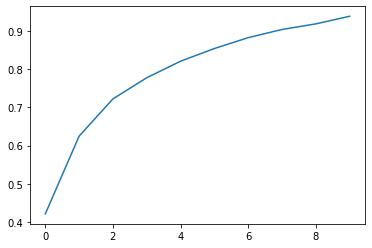

In [160]:
plt.plot(acc)